In [ ]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

Cloning into 'KRSPrediction'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 209 (delta 84), reused 114 (delta 33), pack-reused 0
Receiving objects: 100% (209/209), 3.55 MiB | 8.86 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [ ]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [ ]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [ ]:
krs = krs.drop_duplicates(subset=["date"])

In [ ]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [ ]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3531 non-null   datetime64[ns]
 1   present_storage_tmc  3531 non-null   float64       
 2   inflow               3530 non-null   float64       
 3   outflow              3531 non-null   float64       
 4   max_temp             3531 non-null   float64       
 5   visibility           3531 non-null   float64       
 6   wind                 3531 non-null   float64       
 7   humidity             3531 non-null   float64       
 8   cloudcover           3531 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.9 KB


In [ ]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [ ]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [ ]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [ ]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [ ]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [ ]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [ ]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


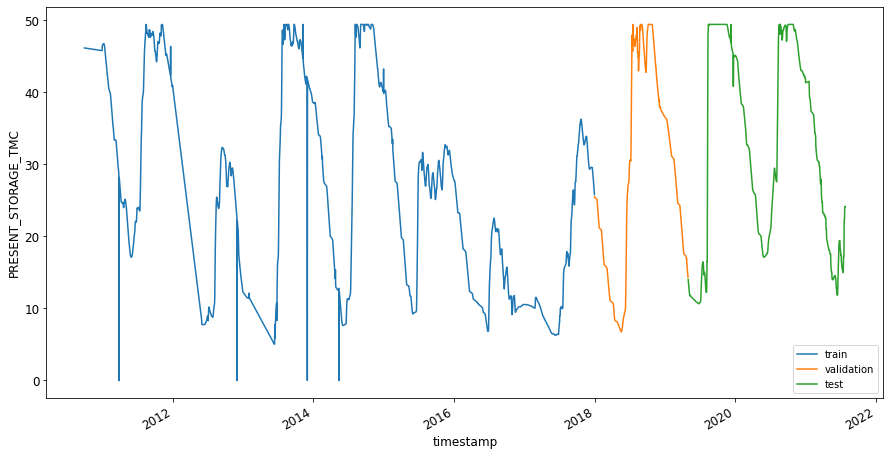

In [ ]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [ ]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [ ]:
train.shape

(2250, 7)

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
flist = list(ts_data_load.columns)

In [ ]:
T = 90
HORIZON = 30
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2017-06-15,0.127401,0.011892,0.005871,0.462617,0.866667,0.628442,0.140123
2012-07-13,0.194135,0.018001,0.028748,0.537383,0.683333,0.598272,0.127820
2016-05-28,0.204449,0.001299,0.006145,0.649533,0.816667,0.601201,0.160629
2011-12-26,0.839636,0.043074,0.060092,0.453271,0.683333,0.316198,0.082023
2017-09-01,0.444085,0.208443,0.112569,0.415888,0.583333,0.796426,0.075871
2015-05-22,0.236805,0.006810,0.003742,0.742991,0.766667,0.677651,0.121668
2016-06-29,0.139737,0.022276,0.014795,0.266355,0.516667,0.901435,0.153110
2017-06-22,0.130030,0.012647,0.010972,0.462617,0.800000,0.689367,0.139440
2015-06-06,0.189282,0.007135,0.002424,0.696262,0.716667,0.639572,0.069720


In [ ]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-89, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = T
BATCH_SIZE = 32
EPOCHS = (
    100
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="adam", loss="mse")


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 90, 90)            26730     
_________________________________________________________________
gru_1 (GRU)                  (None, 90)                49140     
_________________________________________________________________
dense (Dense)                (None, 30)                2730      
Total params: 78,600
Trainable params: 78,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
49/49 [==============================] - 10s 127ms/step - loss: 0.0737 - val_loss: 0.0129
Epoch 2/100
49/49 [==============================] - 5s 110ms/step - loss: 0.0065 - val_loss: 0.0129
Epoch 3/100
49/49 [==============================] - 6s 113ms/step - loss: 0.0052 - val_loss: 0.0129
Epoch 4/100
49/49 [==============================] - 5s 112ms/step - loss: 0.0051 - val_loss: 0.0136
Epoch 5/100
49/49 [==============================] - 6s 113ms/step - loss: 0.0050 - val_loss: 0.0121
Epoch 6/100
49/49 [==============================] - 6s 113ms/step - loss: 0.0049 - val_loss: 0.0130
Epoch 7/100
49/49 [==============================] - 5s 110ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 8/100
49/49 [==============================] - 5s 110ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 9/100
49/49 [==============================] - 6s 112ms/step - loss: 0.0046 - val_loss: 0.0110
Epoch 10/100
49/49 [==============================] - 6s 113ms/step - loss: 0.0046 - val_l

In [ ]:
model.save("90daysto30days")

INFO:tensorflow:Assets written to: 90daysto30days/assets


INFO:tensorflow:Assets written to: 90daysto30days/assets


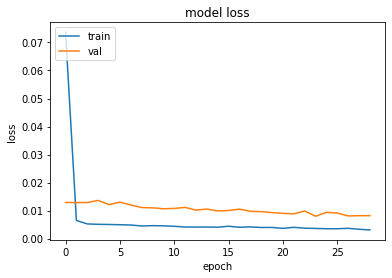

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

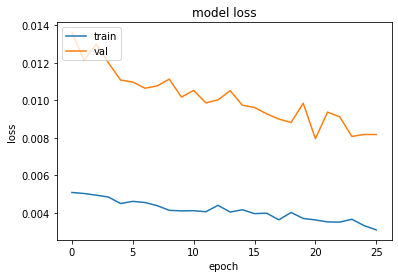

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [ ]:
ts_data_test_inputs['X'].shape

(424, 90, 7)

In [ ]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [ ]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(424, 31)         t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.295737  0.300632  0.297016  ...  0.378295  0.380908 2019-07-30
1  0.283837  0.286964  0.284969  ...  0.361920  0.363300 2019-07-31

[2 rows x 31 columns]
(12720, 3)    timestamp variable  prediction
0 2019-07-30      t+1    0.295737
1 2019-07-31      t+1    0.283837


,timestamp,variable,prediction,actual
935,2020-02-22,t+3,37.022827,34.7700
8747,2021-01-21,t+21,35.066419,36.8865
5444,2021-04-20,t+13,19.983464,18.1330
6658,2021-02-21,t+16,33.583230,30.4540
473,2019-09-17,t+2,51.101486,49.4500


In [ ]:
ts_predictions.shape

(424, 30)

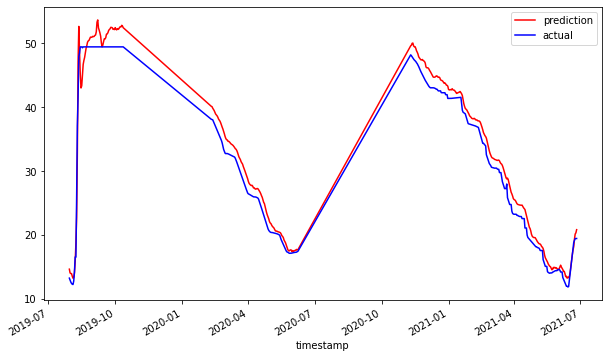

In [ ]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.09660713034108426

In [ ]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [ ]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [ ]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-05-31,t+1,11.571071,11.25,2019-06-01
1,2019-06-01,t+1,11.547426,11.22,2019-06-02


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#finetuning
T = 90
HORIZON = 30
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-04-01,0.219818,0.000730,0.002220,0.654206,0.171429,0.483885,0.048498
2016-01-04,0.560162,0.002174,0.002735,0.420561,0.195238,0.436888,0.068529


In [ ]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-26,0.488493,0.053957,0.015142,0.35514,1.0,0.650149,0.129151


In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=20,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    #callbacks=[earlystop],
    verbose=1,
)

Epoch 1/20
82/82 [==============================] - 9s 109ms/step - loss: 0.0090
Epoch 2/20
82/82 [==============================] - 9s 105ms/step - loss: 0.0073
Epoch 3/20
82/82 [==============================] - 8s 102ms/step - loss: 0.0062
Epoch 4/20
82/82 [==============================] - 8s 102ms/step - loss: 0.0060
Epoch 5/20
82/82 [==============================] - 9s 104ms/step - loss: 0.0058
Epoch 6/20
82/82 [==============================] - 8s 101ms/step - loss: 0.0059
Epoch 7/20
82/82 [==============================] - 9s 105ms/step - loss: 0.0057
Epoch 8/20
82/82 [==============================] - 9s 106ms/step - loss: 0.0055
Epoch 9/20
82/82 [==============================] - 9s 106ms/step - loss: 0.0054
Epoch 10/20
82/82 [==============================] - 8s 102ms/step - loss: 0.0054
Epoch 11/20
82/82 [==============================] - 8s 102ms/step - loss: 0.0053
Epoch 12/20
82/82 [==============================] - 8s 100ms/step - loss: 0.0051
Epoch 13/20
82/82 [======

In [ ]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(2593, 31)         t+1       t+2       t+3  ...      t+29      t+30  timestamp
0  0.441815  0.435082  0.445032  ...  0.347910  0.353186 2011-03-30
1  0.488169  0.482006  0.495148  ...  0.381958  0.380896 2011-03-31

[2 rows x 31 columns]
(77790, 3)    timestamp variable  prediction
0 2011-03-30      t+1    0.441815
1 2011-03-31      t+1    0.488169


,timestamp,variable,prediction,actual
43171,2018-03-31,t+17,8.392806,8.330
75115,2021-04-06,t+29,16.361996,17.982
47458,2015-10-14,t+19,26.558199,26.720
40644,2018-06-05,t+16,21.073828,25.980
72577,2021-05-31,t+28,18.369429,19.431


In [ ]:
model.save("90daysto30days")

INFO:tensorflow:Assets written to: 90daysto30days/assets


INFO:tensorflow:Assets written to: 90daysto30days/assets


In [ ]:
cp -r '/content/90daysto30days/' '/content/gdrive/My Drive/Wave2web/'

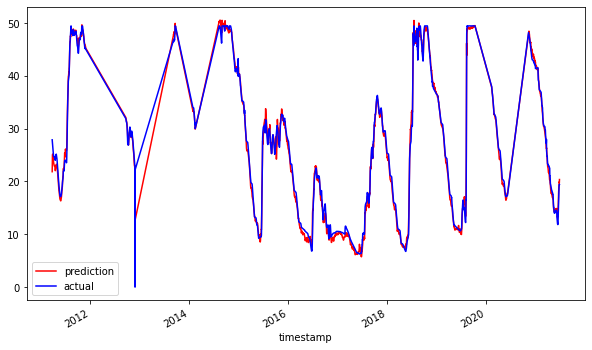

In [ ]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:
import datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [ ]:
ev_all_data.sample(20)

,timestamp,variable,prediction,actual,date
59102,2019-04-08,t+23,13.761671,14.350,2019-05-01
30268,2018-06-01,t+12,15.381641,14.010,2018-06-13
60479,2015-12-09,t+24,27.622732,27.780,2016-01-02
63580,2017-04-30,t+25,6.684496,6.520,2017-05-25
32233,2016-09-11,t+13,13.455780,14.450,2016-09-24
8584,2015-11-04,t+4,29.075548,30.580,2015-11-08
11358,2016-05-03,t+5,9.163891,10.600,2016-05-08
62386,2011-08-31,t+25,47.334621,47.860,2011-09-25
20090,2018-12-12,t+8,36.282551,37.160,2018-12-20
15554,2021-06-23,t+6,22.185718,18.584,2021-06-29


In [ ]:
ev_all_data.to_csv("predictions.csv")

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [ ]:
df = pd.read_csv("predictions.csv")

In [ ]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [ ]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [ ]:
conn.commit()

In [ ]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [ ]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)